In [11]:
import os
import cv2
import numpy as np
from pathlib import Path
from dotenv import load_dotenv
import rootutils

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

rootutils.setup_root(
    os.path.abspath(''), indicator=['.git', 'pyproject.toml'], pythonpath=True
)

from src.data.components.utils import list_files, find_file_by_name, IMAGE_EXTENSIONS

In [12]:
load_dotenv()

True

In [13]:
def fit_image_to_screen(
        image: np.array,
        screen_width: int = 1920,
        screen_height: int = 1080,
        scale: float = 0.75
) -> np.array:
    height, width = image.shape[:2]
    width_scale = float(screen_width) / float(width)
    height_scale = float(screen_height) / float(height)
    width_scale = min(width_scale, 1.0)
    height_scale = min(width_scale, 1.0)
    image_scale = height_scale if width_scale > height_scale else width_scale
    image_scale *= scale
    resized_image = cv2.resize(image, (0, 0), fx=image_scale, fy=image_scale)
    return resized_image

In [14]:
def plot_label_distribution(
        label_pix_sum: int,
        counter: int,
        contour: np.array,
        name: str = 'noname'
) -> None:
    label_pix_sum /= counter
    data = 100.0 * label_pix_sum
    print(f'{data.min()}-{data.max()}')
    cmap = plt.get_cmap('viridis')
    norm = Normalize(vmin=data.min(), vmax=data.max())
    fig, ax = plt.subplots()
    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    im = ax.imshow(data, cmap=cmap, norm=norm)
    cbar = plt.colorbar(sm, ax=ax, format='%d')
    contour_image = np.zeros((label_pix_sum.shape[0], label_pix_sum.shape[1]), dtype=np.uint8)
    cv2.drawContours(contour_image, [contour], -1, 255, thickness=5)
    ax.imshow(contour_image, alpha=0.2)
    cbar.set_label('Label coverage, %')
    plt.title(name)
    plt.show()

In [15]:
def get_contours(image: np.array,
                 threshold_value: int = 127,
                 biggest: bool = True) -> list:
    # threshold
    _, th_image = cv2.threshold(image, threshold_value, 255, cv2.THRESH_BINARY)
    # get all contours from thresholded image
    contours, _ = cv2.findContours(th_image,
                                   mode=cv2.RETR_TREE,
                                   method=cv2.CHAIN_APPROX_NONE)

    # get the biggest contour
    biggest_contour_index = -1
    biggest_area = 0.0
    for i, contour in enumerate(contours):
        contour_area = cv2.contourArea(contour)
        if contour_area > biggest_area:
            biggest_area = contour_area
            biggest_contour_index = i

    if not biggest and contours:
        return contours
    elif biggest and biggest_contour_index != -1:
        return contours[biggest_contour_index]
    else:
        return contours

In [16]:
# Set paths
data_path = Path(os.environ.get('lear_wrinkles_data_path'))
image_path = data_path / 'Photos'
label_path = data_path / 'labels'
outline_path = data_path / 'Outline'

# Gather images and labels
image_paths = list_files(image_path, file_extensions=IMAGE_EXTENSIONS)
label_paths = list_files(label_path, file_extensions=IMAGE_EXTENSIONS)
print(f'Image count: {len(image_paths)}')
print(f'Label count: {len(label_paths)}')

Image count: 854
Label count: 678


0.0-15.53398058252427


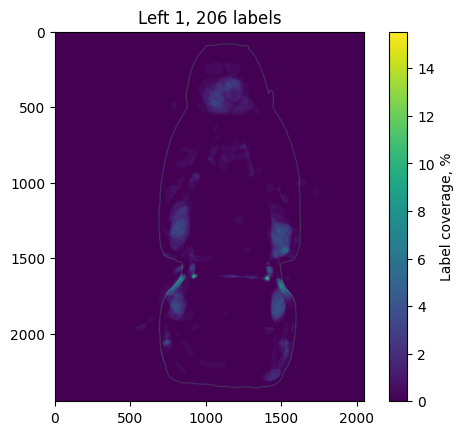

0.0-37.17948717948718


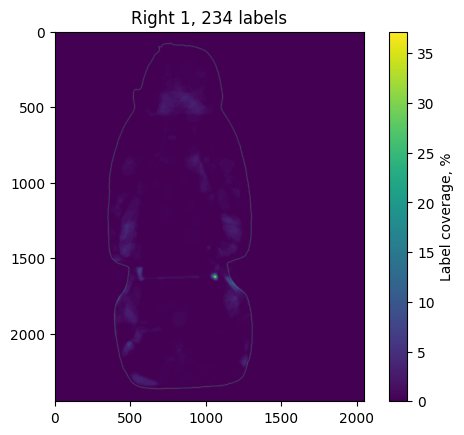

0.0-18.48341232227488


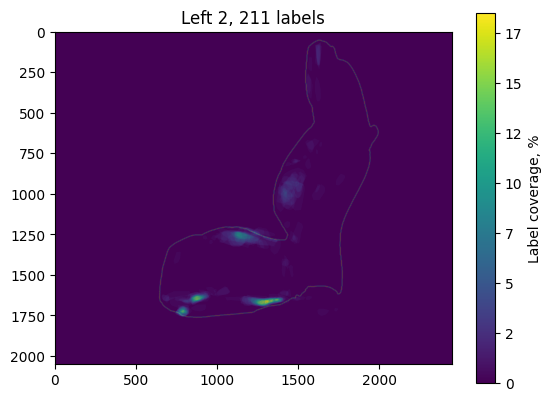

0.0-30.541871921182267


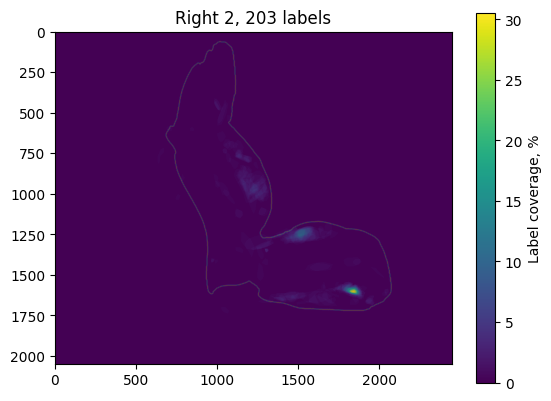

In [17]:
# Define baseline photos
cameras = {'Left 1': '20231006120229-024200994-AC FS Camera Left 1',
           'Right 1': '20231006120219-024200994-AC FS Camera Right 1',
           'Left 2': '20231006120229-024200994-AC FS Camera Left 2',
           'Right 2': '20231006120409-024200994-AC FS Camera Right 2'}

show_images = False

for camera, ref_image_name in cameras.items():
    counter = 0
    label_pix_sum = None
    contour = None
    ref_image = None
    for i, image_path in enumerate(image_paths):
        image_name = image_path.stem
        if camera not in image_name:
            continue
        image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
        counter += 1
        if label_pix_sum is None:
            label_pix_sum = np.zeros((image.shape[0], image.shape[1]), dtype=np.float64)
        image_height, image_width = image.shape[:2]
        # preprocess and segment
        image_RGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask_path = find_file_by_name(outline_path, image_path.stem + '_mask', ['.png'])
        segmentation_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        _, segmentation_mask = cv2.threshold(segmentation_mask, 127, 255, cv2.THRESH_BINARY)
        mask_contours = get_contours(segmentation_mask, biggest=True)
        segmentation_mask.fill(0) # set to zero
        cv2.drawContours(segmentation_mask, [mask_contours], -1, 255, thickness=cv2.FILLED)
        
        label_pth = find_file_by_name(label_path, image_name)
        
        if label_pth is None:
            continue

        label = cv2.imread(label_pth, cv2.IMREAD_GRAYSCALE)
        _, label = cv2.threshold(label, 15, 255, cv2.THRESH_BINARY)
        
        if image_name == ref_image_name:
            contour = mask_contours
            cv2.drawContours(segmentation_mask, [mask_contours], -1, (240, 20, 240), thickness=4)
        # ensure no label pixels outside segmentation regions!
        label_seat = cv2.bitwise_and(label, segmentation_mask)

        # sum
        label_seat_float64 = label_seat.astype(np.float64)
        label_seat_float64 /= 255.0
        label_pix_sum += label_seat_float64

        if show_images:
            image_show = fit_image_to_screen(image)
            label_show = fit_image_to_screen(label_seat)
            segmentation_mask_show = fit_image_to_screen(segmentation_mask)
            cv2.imshow('image', image_show)
            cv2.imshow('label', label_show)
            cv2.imshow('mask', segmentation_mask_show)
            cv2.waitKey(0)

    cv2.destroyAllWindows()

    plot_label_distribution(label_pix_sum, counter, contour, f'{camera}, {counter} labels')